In [15]:
using CSV
using DataFrames
using LaTeXStrings
using Plots; pgfplotsx()
using Statistics

In [16]:
# un-comment and run this cell in order to import the raw data as downloaded from the cluster and aggregate in a single dataframe `df`
# df = DataFrame()
# for i in 1:1000 # loop over job indices as set in the .sh file
#     append!(df, DataFrame(CSV.File("csv/nonsparse_scaling_vs_sparse_nonscaling_grad" * lpad(i, 4, "0") * ".csv")))
# end
# df

In [17]:
# uncomment and run this cell in order to import the aggregated data
df = CSV.read("csv/nonsparse_scaling_vs_sparse_nonscaling_grad.csv", DataFrame)

,filter,eta,sparse_input,beta,dim,mse
,String,Float64,Bool,Float64,Int64,Float64
1,GradientRule,0.5,0,0.1,8,0.334477
2,GradientRule,0.5,1,0.1,8,0.346478
3,GradientRule,0.5,0,0.05,32,0.487324
4,GradientRule,0.5,0,0.0707107,16,0.426061
5,GradientRule,0.5,1,0.1,32,1.22968
6,GradientRule,0.5,1,0.1,16,0.654976
7,GradientRule,0.5,0,0.0353553,64,0.661541
8,GradientRule,0.5,1,0.1,64,1.72349
9,GradientRule,0.5,0,0.025,128,0.877419


In [18]:
# uncomment and run this cell in order to save the aggregated data
# CSV.write("csv/nonsparse_scaling_vs_sparse_nonscaling_grad.csv", df)

In [19]:
# process data
df2 = groupby(df, [:filter, :eta, :sparse_input, :beta, :dim])
df3 = combine(df2, :mse => mean)
df4 = groupby(df3, [:filter, :sparse_input, :beta, :dim])
df5 = combine(df4, :mse_mean => minimum)
df6 = filter(row -> !isnan(row.mse_mean_minimum), df5)

,filter,sparse_input,beta,dim,mse_mean_minimum
,String,Bool,Float64,Int64,Float64
1,GradientRule,0,0.1,8,0.271353
2,GradientRule,1,0.1,8,0.274084
3,GradientRule,0,0.05,32,0.528147
4,GradientRule,0,0.0707107,16,0.388113
5,GradientRule,1,0.1,32,0.99458
6,GradientRule,1,0.1,16,0.622134
7,GradientRule,0,0.0353553,64,0.683177
8,GradientRule,1,0.1,64,0.996713
9,GradientRule,0,0.025,128,0.850548


In [20]:
# uncomment and run this cell in order to save the aggregated data
CSV.write("csv/nonsparse_scaling_vs_sparse_nonscaling_grad_processed.csv", df6)

"csv/nonsparse_scaling_vs_sparse_nonscaling_grad_processed.csv"

In [21]:
dim_rng = [8 * 2^i for i in 0:8]

9-element Vector{Int64}:
    8
   16
   32
   64
  128
  256
  512
 1024
 2048

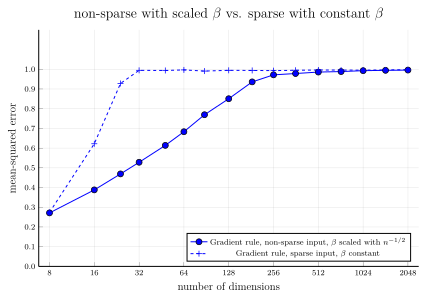

In [22]:
data = filter(row -> row.filter == "GradientRule" && row.sparse_input == false, df6)
sort!(data, order(:dim))
p = plot(
    data[:, :dim], data[:, :mse_mean_minimum], 
    label       = L"Gradient rule, non-sparse input, $\beta$ scaled with $n^{-1/2}$", 
    color       = "blue",    
    markershape = :circle,
    legend      = :bottomright,
    xscale      = :log2,
    xticks      = dim_rng,
    xformatter  = x->Int(x),
    ylims       = (0, 1.2),
    yticks      = 0:0.1:1,
    xlabel      = "number of dimensions",
    ylabel      = "mean-squared error",
    title       = "non-sparse with scaled β vs. sparse with constant β"
)
data = filter(row -> row.filter == "GradientRule" && row.sparse_input == true, df6)
sort!(data, order(:dim))
plot!(
    data[:, :dim], data[:, :mse_mean_minimum], 
    label             = "Gradient rule, sparse input, β constant", 
    color             = "blue", 
    markerstrokecolor = "blue",
    linestyle         = :dash,
    markershape       = :cross
)

In [23]:
# savefig("fig/nonsparse_scaling_vs_sparse_nonscaling_grad.pdf")

In [24]:
dim_rng2 = [8, 16, 24, 32, 48, 64, 128, 256, 512, 1024, 2048]

11-element Vector{Int64}:
    8
   16
   24
   32
   48
   64
  128
  256
  512
 1024
 2048

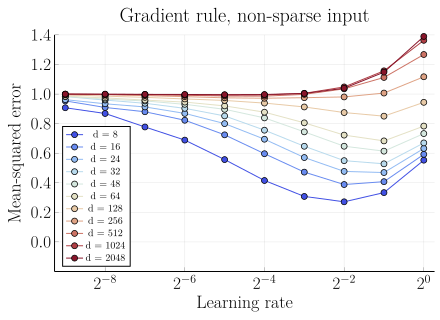

In [25]:
p = plot(
    [], [],
    label       = L"$d = 16$",    
    legend      = :bottomleft,
    xscale      = :log2,
    ylims       = (-0.2, 1.4),
    yticks      = 0:0.2:2.7,
    xlabel      = "Learning rate",
    ylabel      = "Mean-squared error",
    title       = "Gradient rule, non-sparse input",
    titlefont   = (20,),
    tickfont    = (18,),
    guidefont   = (18,),
    legendfontsize = 10,
    color_palette = :thermometer
)
for dim in dim_rng2
    data = filter(row -> row.filter == "GradientRule" && row.sparse_input == false && row.dim == dim, df3)
    sort!(data, order(:eta))
    plot!(
        data[:, :eta], data[:, :mse_mean], 
        label             = "d = $dim",
        markershape = :circle
    )
end
plot!()

In [26]:
savefig("fig/mse_grad_nonsparse.pdf")

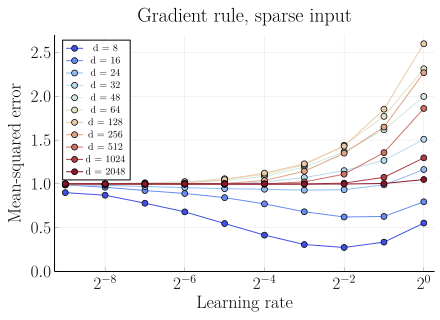

In [27]:
p = plot(
    [], [],  
    legend      = :topleft,
    xscale      = :log2,
    ylims       = (0, 2.7),
    yticks      = 0:0.5:2.6,
    xlabel      = "Learning rate",
    ylabel      = "Mean-squared error",
    title       = "Gradient rule, sparse input",
    titlefont   = (20,),
    tickfont    = (18,),
    guidefont   = (18,),
    legendfontsize = 10,
    color_palette = :thermometer
)
for dim in dim_rng2
    data = filter(row -> row.filter == "GradientRule" && row.sparse_input == true && row.dim == dim, df3)
    sort!(data, order(:eta))
    plot!(
        data[:, :eta], data[:, :mse_mean], 
        label             = "d = $dim", 
        markershape       = :circle
    )
end
plot!()

In [28]:
savefig("fig/mse_grad_sparse.pdf")